In [32]:
# General
! pip install biosppy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import biosppy
from biosppy.signals import ecg

# ML
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Custom
import sys,os
sys.path.append( '.' )
sys.path.append( '..' )
import Components.Outlier_Detection as Outlier_Detection
import Components.Feature_Selection as Feature_Selection
import Components.Normalisation as Normalisation
import Components.data_fetching as data_fetching


# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(Outlier_Detection)
importlib.reload(Feature_Selection)
importlib.reload(Normalisation)
importlib.reload(data_fetching)

<module 'Components.data_fetching' from '../Components/data_fetching.py'>

# Data

In [3]:
X, y = data_fetching.get_train_data()
#x_test = data_fetching.get_test_data()

# Hearbeat extraction

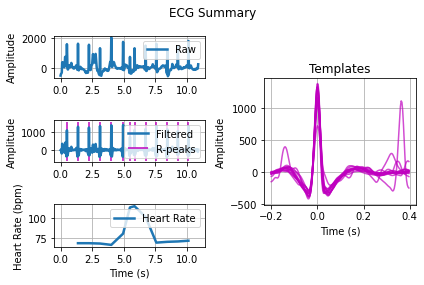

In [37]:
test = X.iloc[0].dropna()
res = ecg.ecg(test[int(len(test)/100):],sampling_rate=300)
# hb = biosppy.signals.ecg.extract_heartbeats(X)

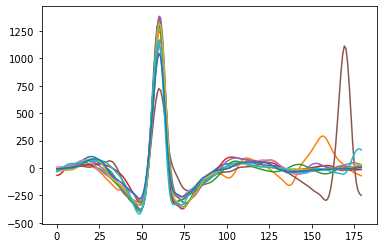

In [36]:
tmps = res["templates"]
tmps = tmps[int(len(tmps)/10):len(tmps)-int(len(tmps)/10)]
plt.plot(tmps.T)

# print(res["templates"])
# print(res["heart_rate"])

In [ ]:
class_2 = np.where(y == 2)[0]
i = np.random.choice(class_2)
print('row:')
print(i)
# to be sure:
print('label:')
print(y.iloc[i])
fs = 300
time = np.arange(X.iloc[i].size) / fs
plt.plot(time, X.iloc[i])
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(0, 10)
#plt.ylim(-1, 1.5)

In [6]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,17969,17970,17971,17972,17973,17974,17975,17976,17977,17978
0,-863.0,-860.0,-857.0,-854.0,-851.0,-849.0,-846.0,-843.0,-838.0,-831.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-137.0,-132.0,-123.0,-107.0,-79.0,-59.0,-45.0,-47.0,-70.0,-107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-727.0,-736.0,-748.0,-784.0,-831.0,-874.0,-917.0,-967.0,-1029.0,-1112.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-103.0,-98.0,-92.0,-87.0,-81.0,-77.0,-71.0,-65.0,-61.0,-59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,2.0,-1.0,-3.0,-5.0,-7.0,-10.0,-12.0,-14.0,-14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
print(X.iloc[0].dropna())

0      -863.0
1      -860.0
2      -857.0
3      -854.0
4      -851.0
        ...  
3296     84.0
3297    118.0
3298    147.0
3299    188.0
3300    231.0
Name: 0, Length: 3301, dtype: float64


In [214]:
import neurokit as nk
from pprint import pprint

signal = X.iloc[0].dropna()
ecg_preprocessed = nk.ecg_preprocess(signal, sampling_rate=300)
# t_peaks = ecg_preprocessed["ECG"]["T_Waves"]
# p_peaks = ecg_preprocessed["ECG"]["P_Waves"]
# q_peaks = ecg_preprocessed["ECG"]["Q_Waves"]
# r_peaks = ecg_preprocessed["ECG"]["R_Peaks"]
# cycles = ecg_preprocessed["ECG"]["Cardiac_Cycles"]
# peaks = [p_peaks,q_peaks,r_peaks,t_peaks]

# Fetch peak arrays: [p,q,r,t]
peaks = [ecg_preprocessed["ECG"]["P_Waves"],ecg_preprocessed["ECG"]["Q_Waves"],list(ecg_preprocessed["ECG"]["R_Peaks"]),ecg_preprocessed["ECG"]["T_Waves"]]


def peaks_cleaning(peaks):
    # peak ordering is p<q<r<t
    # => first index > p[0]
    p_min = peaks[0][0]
    peaks = [[ind for ind in p if ind >= p_min] for p in peaks]
    
    # median r_peak distance used later
    med = 200 #np.median(np.diff(peaks[2]))
    
    # Obtain valid <p,q,r,t> pairs
    # assume p,q,r,t each ordered asc.
        # for each possible <p,q,r,t>
            # if p>q,r,t then we can never for a valid pair with q,r,t so drop q,r,t
                # repeat until p<q,r,t
                # same with p<q>r,t, p<q<r>t,
            # cont until p<q<r<t, then check that p<q<r<t is feasible
    i = -1
    while i < len(peaks[0]):
        i += 1
        if i <= np.min(list(map(len, peaks)))-1:
            for j in range(len(peaks)-1):
                while (peaks[j][i] > peaks[j+1][i]):
                    peaks[j+1].pop(i)
            # TODO: Check valid
            if peaks[-1][i] - peaks[0][i] > med:
                peaks[0].pop(i)
                i -= 1
        else:
            for i in range(len(peaks)):
                peaks[i] = peaks[i][:np.min(list(map(len, peaks)))]
            break
    return peaks

pprint(peaks)
pprint(peaks_cleaning(peaks))

[[387, 689, 930, 1199, 1459, 1650, 1772, 2013, 2285, 2526, 2773, 3007],
 [435, 695, 958, 1226, 1506, 1668, 1778, 2039, 2295, 2555, 2806, 3057],
 [183, 446, 706, 969, 1237, 1517, 1680, 1789, 2050, 2306, 2567, 2817, 3068],
 [287, 511, 802, 1084, 1307, 1562, 1733, 1854, 2114, 2425, 2685, 2879]]
[[387, 689, 930, 1199, 1459, 1650, 1772, 2013, 2285, 2526, 2773],
 [435, 695, 958, 1226, 1506, 1668, 1778, 2039, 2295, 2555, 2806],
 [446, 706, 969, 1237, 1517, 1680, 1789, 2050, 2306, 2567, 2817],
 [511, 802, 1084, 1307, 1562, 1733, 1854, 2114, 2425, 2685, 2879]]


In [215]:
import copy as cp

test = [[387, 689, 930, 1199, 1459, 1650, 1772, 2013, 2285, 2526, 2773, 3007],
 [435, 695, 958, 1226, 1506, 1668, 1778, 2039, 2295, 2555, 2806, 3057],
 [183, 446, 706, 969, 1237, 1517, 1680, 1789, 2050, 2306, 2567, 2817, 3068],
 [287, 511, 802, 1084, 1307, 1562, 1733, 1854, 2114, 2425, 2685, 2879]]

print("Test 1:")
t1 = cp.deepcopy(test)
t1[0][0] = None
pprint(t1)
t1[0].pop(0)
pprint(peaks_cleaning(t1))

print("\nTest 2:")
t2 = cp.deepcopy(test)
t2[2][5] = None
pprint(t2)
t2[2].pop(5)
pprint(peaks_cleaning(t2))

p_t2 = peaks_cleaning(t2)
print(np.array(p_t2[-1])-np.array(p_t2[0]))

Test 1:
[[None, 689, 930, 1199, 1459, 1650, 1772, 2013, 2285, 2526, 2773, 3007],
 [435, 695, 958, 1226, 1506, 1668, 1778, 2039, 2295, 2555, 2806, 3057],
 [183, 446, 706, 969, 1237, 1517, 1680, 1789, 2050, 2306, 2567, 2817, 3068],
 [287, 511, 802, 1084, 1307, 1562, 1733, 1854, 2114, 2425, 2685, 2879]]
[[689, 930, 1199, 1459, 1650, 1772, 2013, 2285, 2526, 2773],
 [695, 958, 1226, 1506, 1668, 1778, 2039, 2295, 2555, 2806],
 [706, 969, 1237, 1517, 1680, 1789, 2050, 2306, 2567, 2817],
 [802, 1084, 1307, 1562, 1733, 1854, 2114, 2425, 2685, 2879]]

Test 2:
[[387, 689, 930, 1199, 1459, 1650, 1772, 2013, 2285, 2526, 2773, 3007],
 [435, 695, 958, 1226, 1506, 1668, 1778, 2039, 2295, 2555, 2806, 3057],
 [183, 446, 706, 969, 1237, None, 1680, 1789, 2050, 2306, 2567, 2817, 3068],
 [287, 511, 802, 1084, 1307, 1562, 1733, 1854, 2114, 2425, 2685, 2879]]
[[387, 689, 930, 1199, 1650, 1772, 2013, 2285, 2526, 2773],
 [435, 695, 958, 1226, 1668, 1778, 2039, 2295, 2555, 2806],
 [446, 706, 969, 1237, 1680, 17

In [181]:
print(np.diff(peaks[2]))

[263 260 263 268 280 163 109 261 256 261 250 251]
